# Elliptic and parabolic partial differential equations (PDEs) via finite differences

Code with some extra solutions

1. Some hints concerning sparse matrices
2. Boundary layers for 1D problems
3. Index slicing in higher dimensions

In [52]:
# sparse matrices
from scipy import sparse

ii = [0,1,2,2]
jj = [0,1,2,3]
aa = [1.0,1.5,2.5,5]
Lh = sparse.csr_matrix((aa,(ii,jj)),shape=(3,4))

r  = [1,2,3,4] 
rc = np.array([[1,2,3,4]]).T
rr = np.array([[1,2,3,4]])

print(rc,"\n")
print(rr,"\n")

print(Lh,"\n")

print(Lh*rc,"\n")
print(Lh*r,"\n")

M = Lh.todense()
print(M,"\n")
print(M*rc,"\n")

[[1]
 [2]
 [3]
 [4]] 

[[1 2 3 4]] 

  (0, 0)	1.0
  (1, 1)	1.5
  (2, 2)	2.5
  (2, 3)	5.0 

[[ 1. ]
 [ 3. ]
 [27.5]] 

[ 1.   3.  27.5] 

[[1.  0.  0.  0. ]
 [0.  1.5 0.  0. ]
 [0.  0.  2.5 5. ]] 

[[ 1. ]
 [ 3. ]
 [27.5]] 



## 1. 1D elliptic problem

Solve the elliptic 1D problem for a function $u:[0,L]\to\mathbb{R}$

$$
-a\,u''(x) + b\,u'(x) + c\,u(x)=f(x)
$$

with Dirichlet boundary condition $u(0)=\alpha, u(L)=\beta$. We assume that $a>0$ and $c\ge 0$, so that the problem is always a well-posed elliptic PDE. As discussed, this problem is discretized via

$$
u''(x_n) \approx \frac{u^h_{n-1}-2u^h_{n}+u^h_{n+1}}{h^2}
$$
$$
u'(x_n) \approx \frac{u^h_{n+1}-u^h_{n-1}}{2h}
$$

where $u^h_n \approx u(x_n)$ and $x_n = nh$ for $h=L/(N+1)$ and $n=\{0,1,...,N+1\}$.

For example, an exact solution for $a=L=1$ and $\alpha=\beta=b=c=0$ and $f(x)=1$ is

$$
u(x)=\frac12 x(1-x).
$$

**Questions:**

1. Confirm the correctness of the code by comparing with other exact solutions for different values of $\alpha,\beta,b,c$ and possibly other $f(x)$.

*Hint:* In Wolfram alpha try to input `-u''[x]=1 and u[0]=0 and u[1]=0` and expand on that answer.

2. What are advantages and disadvantages/limitation of this discretization?
3. Can you show why the approximations for $u''$ and $u'$ are valid? 

*Hint:* Taylor expansions.

4. What other boundary conditions (bc) could be relevant? How would you implement/discretize those?

*Hint:* Dirichlet bc, Neumann bc, periodic bc, far-field conditions, ...  

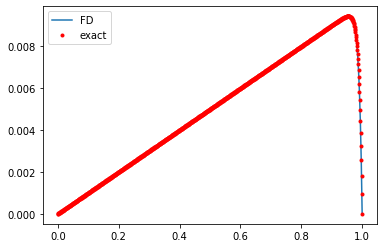

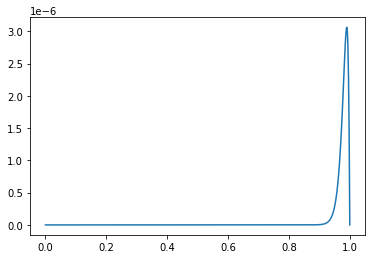

In [60]:
import numpy as np
from scipy.sparse.linalg import spsolve
from scipy import sparse
import matplotlib.pyplot as plt

# parameters
N = 1000
L = 1.0
k = N + 2    # define k = N+2 for ease of typing
h = L/(k-1)  # lattice spacing

# create mesh using meshgrid
xh = np.linspace(0,L,k)

# index for points and their neighbors
ix   = np.arange(0,k) # create indices in lexic. ordering
ixy  = ix[1:-1]       # index i
ixm  = ix[0:-2]       # index i-1
ixp  = ix[2:]         # index i+1

ix_BD = ix[(xh<h/2)|(xh>L-h/2)]

# create sparse matrix i and j index
ii = np.concatenate((ixy,ixy,ixy,ix_BD)); # sparse row    i
jj = np.concatenate((ixy,ixm,ixp,ix_BD)); # sparse column j

# create sparse matrix a(i,j) component
ee  = np.ones(((k-2),1));
ee1 = np.ones((np.size(ix_BD),1))

alpha = 0
beta  = 0

a   = 1
b   = 100
c   = 0

s0  = +2*a/h**2          + c
sm  = -1*a/h**2 - b/(2*h)
sp  = -1*a/h**2 + b/(2*h)
aa  = np.concatenate((ee*s0,ee*sm,ee*sp,ee1))

# build sparse matrix Lh and rhs 
Lh      = sparse.csr_matrix((aa.flatten(),(ii.flatten(),jj.flatten())),shape=(k,k))
rhs     = 1+0*xh
rhs[0]  = alpha
rhs[-1] = beta

# solve linear system
u = spsolve(Lh, rhs)

fig = plt.figure()
plt.plot(xh,u,label='FD')

#xh  = np.linspace(0,1,64)
yy  = xh*(1-xh)/2

eb  = np.exp(b)
ebx = np.exp(b*xh)
yy  = (ebx+xh-1-eb*xh)/(b*(1-eb))

plt.plot(xh,yy,'r.',label='exact')
plt.legend()

plt.figure()
plt.plot(xh,u-yy)

## 2. 2D elliptic problem

Here we solve a corresponding two-dimensional elliptic problem for a function $u:[0,L]^2\to\mathbb{R}$, i.e.

$$
-\Delta u(x) = f(x) \qquad x\in\Omega=[0,L]^2 
$$

and Dirichlet boundary conditions $u(x)=g(x)$ for $x\in\partial\Omega$. For the discretization of the Laplacian $\Delta$ we use, with $x=(x_i,y_j)$ the 2D finite difference approximation

$$
-\Delta u(x_i,y_j)\approx -\Delta_h u_h(x_i,y_j)=\frac{1}{h^2}\Big(4 u_h(x_i,y_j) - u_h(x_{i-1},y_j)- u_h(x_{i+1},y_j)- u_h(x_{i},y_{j-1})- u_h(x_{i},y_{j+1})\Big)
$$

where here $\Delta_h$ is the discrete Laplacian which acts on a vector consisting of the components $u_h(x_i,y_j)$ in lexicographical ordering. Boundary conditions are handeled via a condition $u_h(x_i,y_j)=g(x_i,y_j)$ for $(x_i,y_j)\in\partial\Omega$.

**Questions:**

1. Compare with 1D with the 2D implementation and point out differences.
2. Can you infer from 1. how a 3D implementation would look like?
3. What is the size of the matrix for any $N$?
4. How does to time to solve scale (roughly) with $N$?
5. How would you extend to

$$
-\nabla\cdot (a(x)\nabla u(x))=f(x),
$$

$$
-\nabla\cdot (a(x)\nabla u(x))+\vec{b}(x)\cdot\nabla u(x)+c(x)u(x)=f(x),
$$

or implement complex domains, different boundary conditions? Not try to implement, just think about how it could be done.

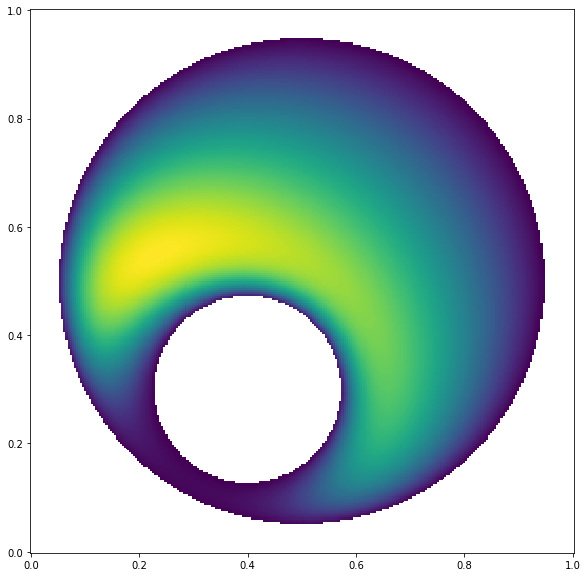

In [19]:
import numpy as np
from scipy.sparse.linalg import spsolve
from scipy import sparse
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# parameters
N = 256
L = 1.0
k = N + 2    # define k = N+2 for ease of typing
h = L/(k-1)  # lattice spacing

# create mesh using meshgrid
xh, yh = np.meshgrid(np.linspace(0,L,k), np.linspace(0,L,k)) 
xh = np.transpose(xh);
yh = np.transpose(yh);

# index for points and their neighbors
ix   = np.reshape(np.arange(0,k**2),(k,k)).T # create indices in lexic. ordering
ixy  = ix[1:-1,1:-1].flatten()   # index (i,j)
ixmy = ix[0:-2,1:-1 ].flatten()  # index (i-1,j)
ixpy = ix[2:,1:-1].flatten()     # index (i+1,j)
ixym = ix[1:-1,0:-2].flatten()   # index (i,j-1)
ixyp = ix[1:-1,2:].flatten()     # index (i,j+1)

# index boundary points
ix_BD = ix[(yh<h/2)|(xh<h/2)|(xh>L-h/2)|(yh>L-h/2)].T

# create sparse matrix i and j index
ii = np.concatenate((ixy,ixy,ixy,ixy,ixy,ix_BD));     # sparse row    i
jj = np.concatenate((ixy,ixmy,ixpy,ixym,ixyp,ix_BD)); # sparse column j

# create sparse matrix a(i,j) component
ee  = np.ones(((k-2)**2,1));
ee1 = np.ones((np.size(ix_BD),1))

ux  = -20.0
uy  = -20.0

axy = (+4)/h**2
apy = (-1)/h**2 + ux * (+1)/(2*h)
amy = (-1)/h**2 + ux * (-1)/(2*h)
axp = (-1)/h**2 + uy * (+1)/(2*h)
axm = (-1)/h**2 + uy * (-1)/(2*h)

aa  = np.concatenate((ee*axy,ee*amy,ee*apy,ee*axm,ee*axp,ee1))

# build sparse matrix Lh and rhs 
#Lh  = sparse.csr_matrix((aa.flatten(),(ii.flatten(),jj.flatten())),shape=(k*k,k*k))
Lh  = sparse.csc_matrix((aa.flatten(),(ii.flatten(),jj.flatten())),shape=(k*k,k*k))

rhs = 1 + 0*xh.flatten()

g = np.tanh((yh.flatten()-0.5)*50).T

rhs[ix_BD] = g[ix_BD]
# solve linear system

# SOL
r1 = (xh-L/2)**2+(yh-L/2)**2
r2 = (xh-0.4)**2+(yh-0.3)**2


sel1 = (r1.flatten()<0.2)
sel2 = (r2.flatten()>0.03)

sel = np.logical_and(sel1,sel2)
u=np.nan + 0*xh.flatten()

Lx1 = Lh[sel,:]
Lxx = Lx1[:,sel]

u[sel] = spsolve(Lxx, rhs[sel])
u = np.reshape(u,(k,k))

##
#u = spsolve(Lh, rhs)
#u = np.reshape(u,(k,k))

# plot solution
fig = plt.figure(figsize=(10,10))

ax  = fig.add_subplot(111)
ax.set_aspect('equal')
plt.pcolormesh(xh, yh, u,shading='auto')

#ax  = fig.add_subplot(111, projection='3d')
#ax.plot_surface(xh,yh,u,cmap=cm.jet)
#plt.show()


## 3. 1D parabolic problem

In 1. we saw the 1D elliptic problem and now abbreviate the operator

$$
Lu = -a\,u'' + b\,u' + c\,u,
$$

that appeared in the elliptic problem. Here, $L$ maps a twice continuously differentiable (in space $x$) function $u$ to the continuous (in space) function $Lu$, given that also $a>0,b,c\ge 0$ are sufficiently smooth. Here we consider those functions just as constants. Depending on the situation, $L$ might or might not contain also terms that reflect the boundary conditions.

For a function $u:[0,T]\times[0,L]\to\mathbb{R}$ we now want to discuss the problem

$$
\partial_t u(t,x) + L u(t,x) = f(x)
$$

with initial condition $u(t=0,x)=u_0(x)$ and boundary conditions $u(t,0)=\alpha$ and $u(t,L)=\beta$. The right side $f$ could also depend on time. We denote

$$
u^k_i=u(t_k,x_i),\qquad t_k = \tau k,\quad x_i=ih,
$$

with time-step size $\tau$ and mesh-size $h=L/(N+1)$. Then using the abbreviation

$$
(L_h u)^k_i (t_k,x_i)=-a\frac{u^k_{i-1}-2u^k_{i}+u^k_{i+1}}{h^2}+b\frac{u^k_{i+1}-u^k_{i-1}}{2h} + c u^k_i
$$

we use the discretization (implicit Euler scheme)

$$
\frac{u^{k+1}_i-u^k_i}{\tau} + (L_h u)^{k+1}_i = f(x_i)
$$

for $i\in\{1,...,N\}$ and use boundary conditions for $i=0$ and $i=N+1$. In practise we need to solve a linear equation $A u^{k+1} = b$ where

$$
A=\mathbb{I}_{N+2} + \tau L_h, \qquad b=u^{k} + \tau f.
$$

One needs to be careful with first and last line and component of $A$ and $b$, since they determine the boundary condition.

**Questions:**

1. Confirm the correctness of the code by comparing with exact solutions. Those you can obtain by a separation of variables $u(t,x)=u_1(t)u_2(x)$ ansatz, Fourier modes, by determining eigenfunctions of $L_h$. Perhaps try $u(t,x)=\exp(\lambda t)\sin(kx)$.

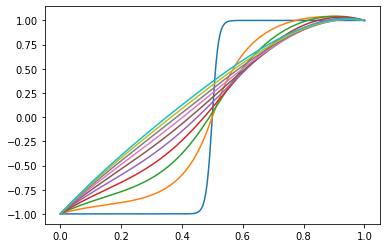

In [6]:
import numpy as np
from scipy.sparse.linalg import spsolve
from scipy import sparse
import matplotlib.pyplot as plt

# parameters
N   = 500
L   = 1.0
k   = N + 2    # define k = N+2 for ease of typing
h   = L/(k-1)  # lattice spacing
Nt  = 10
tau = 1e-2

# create mesh using meshgrid
xh = np.linspace(0,L,k)

# index for points and their neighbors
ix   = np.arange(0,k) # create indices in lexic. ordering
ixy  = ix[1:-1]       # index i
ixm  = ix[0:-2]       # index i-1
ixp  = ix[2:]         # index i+1

ix_BD = ix[(xh<h/2)|(xh>L-h/2)]

# create sparse matrix i and j index
ii = np.concatenate((ixy,ixy,ixy)); # sparse row    i
jj = np.concatenate((ixy,ixm,ixp)); # sparse column j

# create sparse matrix a(i,j) component
ee  = np.ones(((k-2),1));

alpha = 0
beta  = 0

a   = 1
b   = 2
c   = 0

s0  = +2*a/h**2       + c
sm  = -1*a/h**2 - b/(2*h)
sp  = -1*a/h**2 + b/(2*h)
aa  = np.concatenate((ee*s0,ee*sm,ee*sp))

# build sparse matrix Lh and rhs 
Ih      = sparse.identity(k)
Lh      = sparse.csr_matrix((aa.flatten(),(ii.flatten(),jj.flatten())),shape=(k,k))
fh      = 10 + 0*xh
u       = np.tanh((xh-L/2)*50)

fh[ 0]=0
fh[-1]=0

Ah = Ih + tau*Lh

fig = plt.figure()
for k in range(Nt):
    plt.plot(xh,u,label='FD')
    rhs = u + tau*fh
    u = spsolve(Ah, rhs)